Download attack data from into csv file

In [25]:
import os

from dotenv import load_dotenv

from wandb_download import extract_wandb_runs_to_csv

load_dotenv()  # Load environment variables from .env file
project_attacks = os.getenv("WANDB_PROJECT")
project_corruptions = os.getenv("WANDB_PROJECT_CORRUPTIONS")
entity_name = os.getenv("WANDB_ENTITY")
assert project_attacks, "Please set the WANDB_PROJECT environment variable"
assert project_corruptions, "Please set the WANDB_PROJECT_CORRUPTIONS environment variable"
assert entity_name, "Please set the WANDB_ENTITY environment variable"

extract_wandb_runs_to_csv(project_attacks, entity_name, "attacks_results.csv")
extract_wandb_runs_to_csv(project_corruptions, entity_name, "corruptions_results.csv")

## Attacks

In [ ]:
import pandas as pd

attack_result_csv = "attacks_results.csv"
df = pd.read_csv(attack_result_csv)
df

In [ ]:
len(df["id"].unique())

In [ ]:
df.columns.tolist()

/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

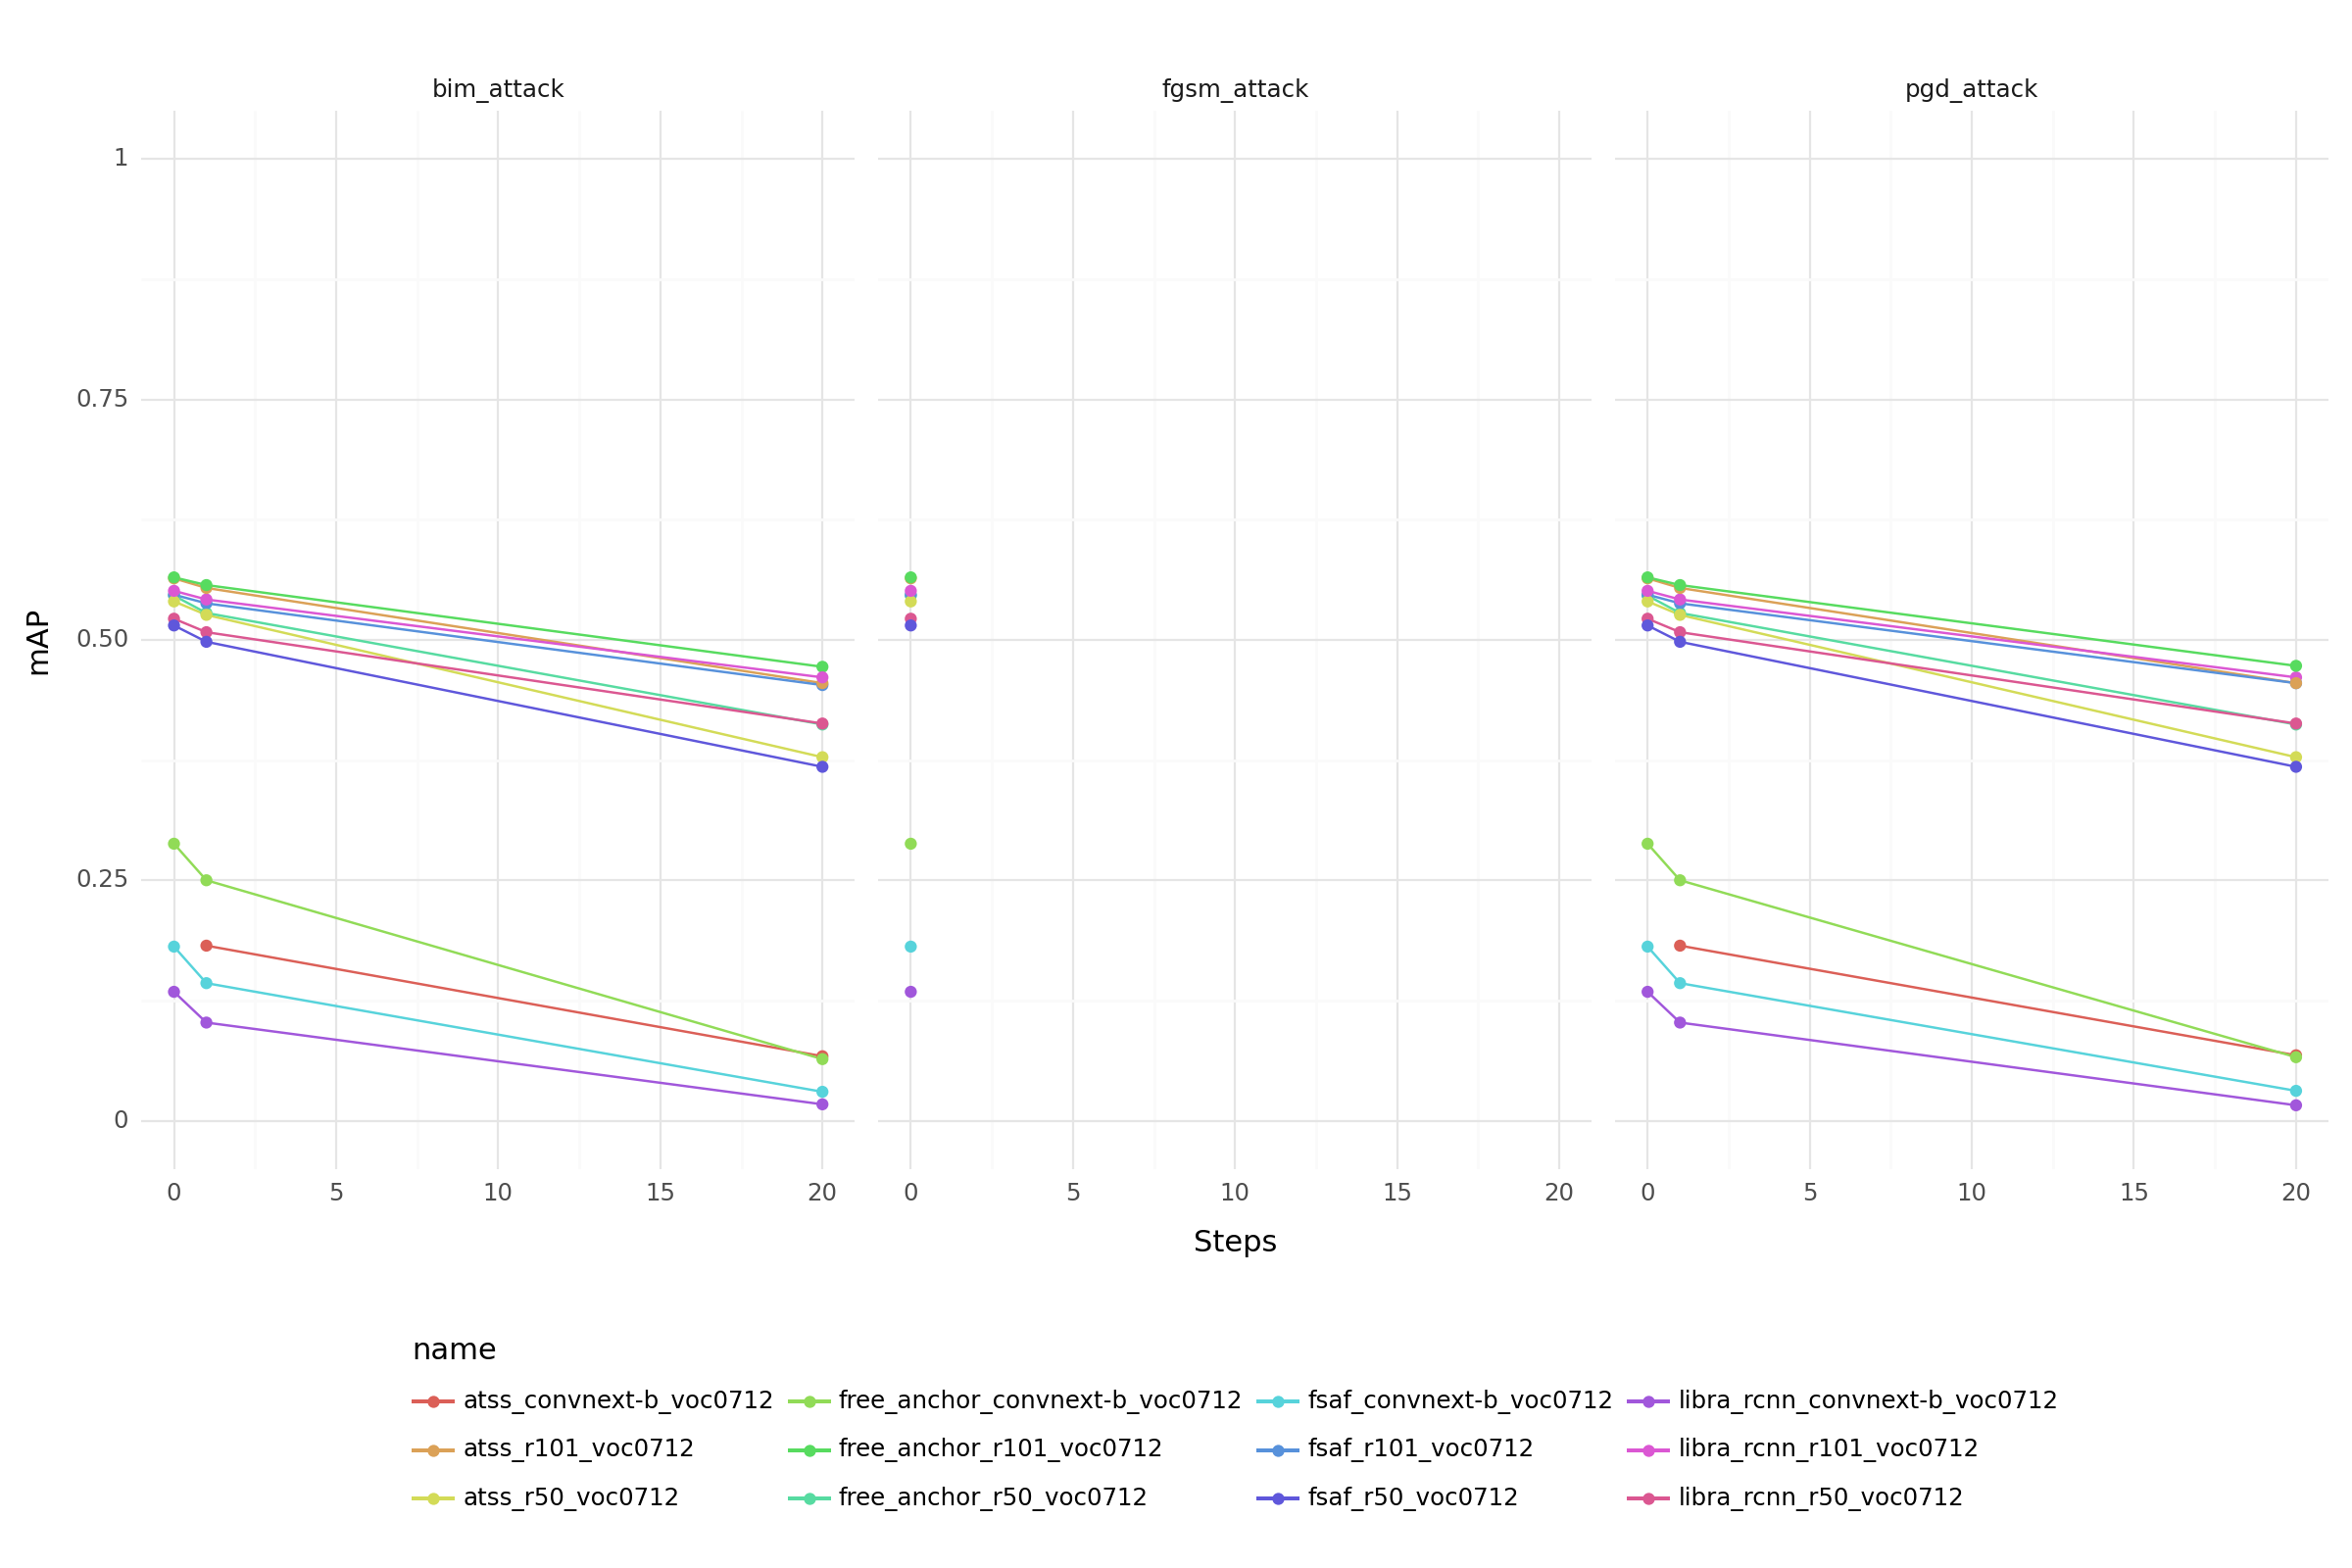

<Figure Size: (1200 x 800)>

In [5]:
from pandas import DataFrame
from plotnine import (
    aes,
    facet_grid,
    facet_wrap,
    geom_line,
    geom_point,
    ggplot,
    labs,
    scale_y_continuous,
    theme,
    theme_minimal,
)


def prepare_df_plot(input_file: str):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Preprocess the DataFrame
    df = df.filter(regex="attack|^name$|mAP|state|step|^id$|data_root")
    df = df[df["coco/bbox_mAP"].notna()]

    # if step is missing, keep only one row per id
    # this deals with previous versions of the code that did not save metrics at each step
    df = df.drop_duplicates(subset=["id", "step"], keep="first", ignore_index=True)
    df.loc[df["step"].isna(), 'old_school'] = True
    df.loc[df["step"].notna(), 'old_school'] = True
    df["step"] = df["step"].fillna(df["attack_kwargs.steps"])
    df.loc[df["attack_kwargs.norm"].isna(), 'attack_kwargs.norm'] = "inf"
    df_old: DataFrame = df[df["old_school"]]  

    # treat none attack as zeroth step of each attack
    # only relevant for old runs
    no_attacks_df = df_old[df_old["attack"] == "none"].copy()
    pgd_df = no_attacks_df.copy()
    pgd_df["attack"] = "pgd_attack"

    bim_df = no_attacks_df.copy()
    bim_df["attack"] = "bim_attack"

    df.loc[df["attack"] == "fgsm_attack", 'attack_kwargs.steps'] = 1
    fgsm_df = no_attacks_df.copy()
    fgsm_df["attack"] = "fgsm_attack"

    df = pd.concat([df, pgd_df, bim_df, fgsm_df], ignore_index=True)

    # Only keep the relevant columns and drop rows with NaN values
    df_filtered = df[['coco/bbox_mAP', 'step', 'name', 'attack', 'data_root', "attack_kwargs.epsilon", "attack_kwargs.alpha", "attack_kwargs.norm"]].dropna()
    df_filtered = df_filtered[df_filtered['attack'] != 'none']
    df_filtered["attack_kwargs.epsilon"] = df_filtered["attack_kwargs.epsilon"].astype(int)
    df_filtered["step"] = df_filtered["step"].astype(int)
    
    return df_filtered

def plot_mAP_vs_steps(dataset_root: str, df) -> None:
    df = df[df["data_root"] == dataset_root]

    plot = (ggplot(df, aes(x='step', y='coco/bbox_mAP', color='name'))
            + geom_line()
            + geom_point()
            + labs(x='Steps',
                   y='mAP')
            + theme_minimal()
            + facet_wrap('attack')
            + scale_y_continuous(limits=(0, 1))
            + theme(figure_size=(12, 8),
                    legend_position='bottom'))  # Set legend position to bottom

    return plot

df = prepare_df_plot(attack_result_csv)
plot_mAP_vs_steps("data/VOCdevkit/", df)

/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future vers

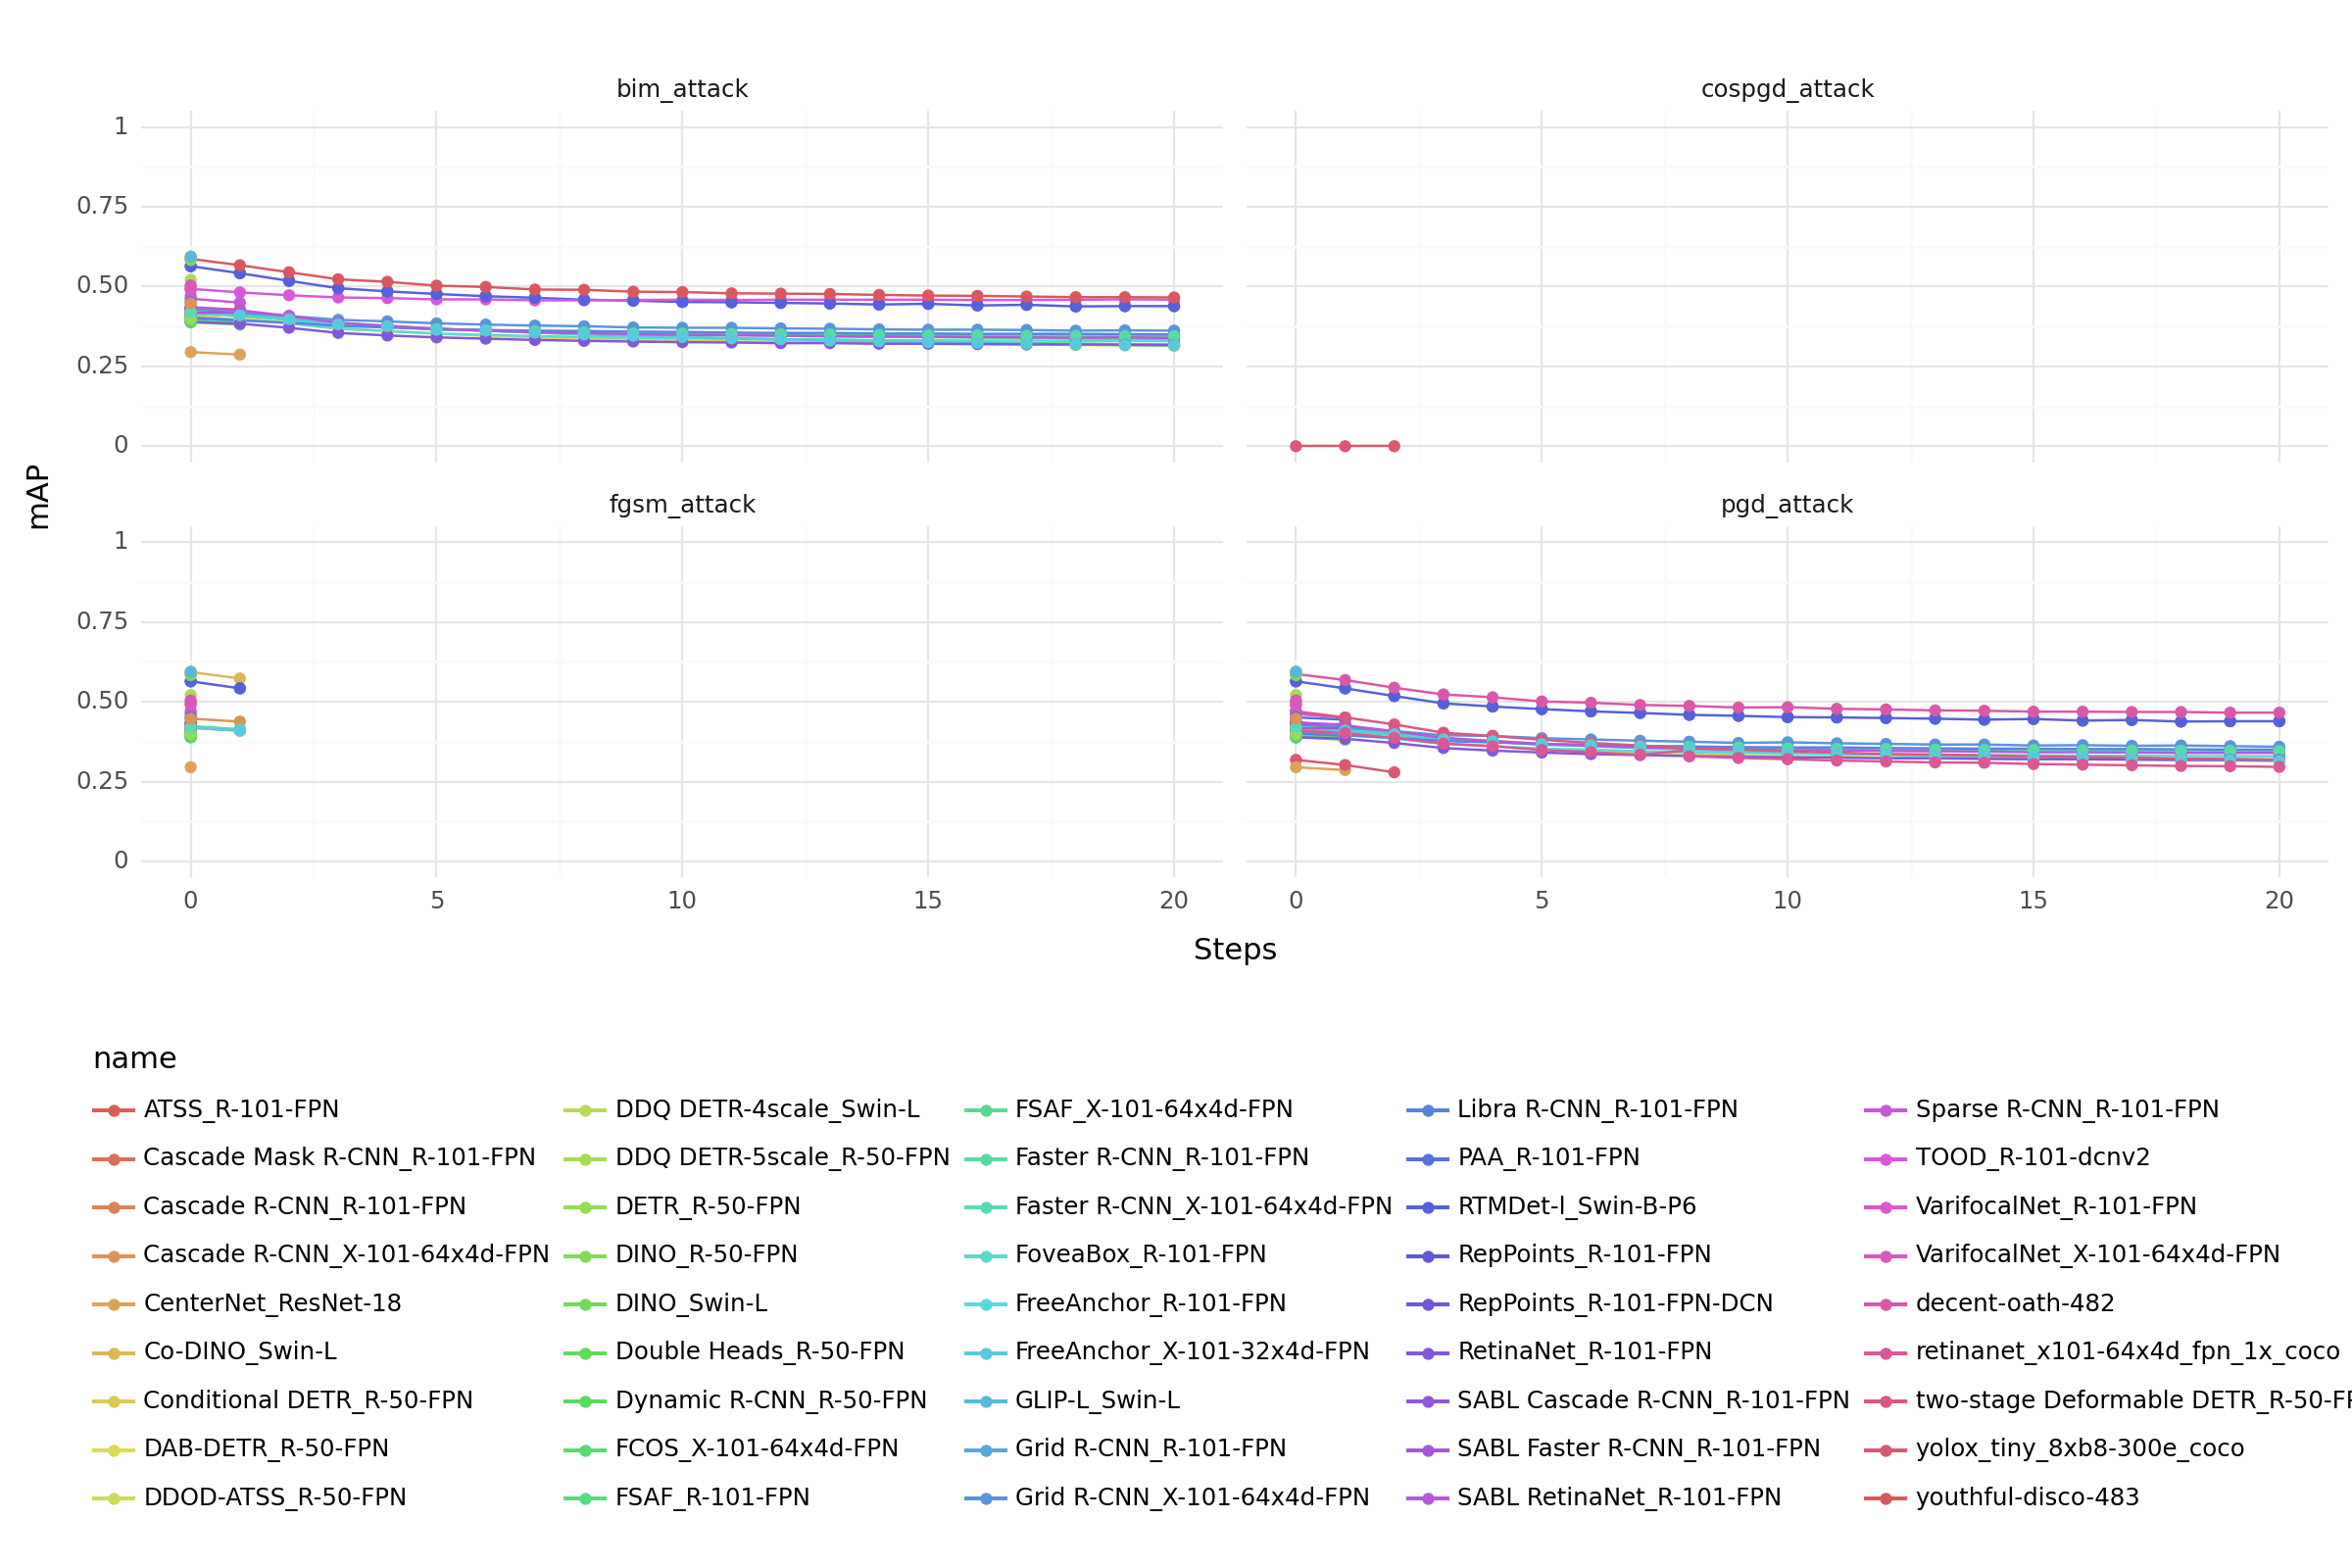

<Figure Size: (1200 x 800)>

In [6]:
plot_mAP_vs_steps("data/coco/", df)

In [7]:
# # make backend variable
# df_filtered['backend'] = ""
# df_filtered.loc[df_filtered['name'].str.contains('R-101|R-50|r50|r101|ResNet'), 'backend'] = 'ResNet'
# df_filtered.loc[df_filtered['name'].str.contains('Swin'), 'backend'] = 'Swin'
# df_filtered.loc[df_filtered['name'].str.contains('convnext'), 'backend'] = 'ConvNext'


# plot = (ggplot(df_filtered, aes(x='attack_kwargs.steps', y='coco/bbox_mAP', color='name'))
#         + geom_line()
#         + geom_point()
#         + labs(x='Steps',
#                y='mAP')
#         + theme_minimal()
#         + facet_grid(('attack', 'backend'))
#         + scale_y_continuous(limits=(0, 1))
#         + theme(figure_size=(12, 12),
#                 legend_position='bottom'))  # Set legend position to bottom

# plot

In [8]:
# df = pd.read_csv("project.csv")

# # Preprocess the DataFrame
# df = df.filter(["name", "attack", "attack_kwargs.steps", "attack_kwargs.epsilon", "attack_kwargs.alpha", "attack_kwargs.norm", "state"])
# df.loc[df["attack"] == "none", 'attack_kwargs.steps'] = 0
# df.loc[df["attack"] == "fgsm_attack", 'attack_kwargs.steps'] = 1
# df.loc[df["attack"] == "pgd_attack", 'attack_kwargs.norm'] = "none"
# df.loc[df["attack"] == "none", 'attack_kwargs.norm'] = "none"
# df.loc[df["attack"] == "none", 'attack_kwargs.epsilon'] = 0
# df.loc[df["attack"] == "none", 'attack_kwargs.alpha'] = 0

# df.isna().sum()

In [9]:
def prepare_df_status_table(input_file: str):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(attack_result_csv)

    # Preprocess the DataFrame
    df = pd.read_csv(attack_result_csv)
    df = df.filter(regex="attack|^name$|bbox|state|step|^id$|data_root")

    # if step is missing, keep only one row per id
    # this deals with previous versions of the code that did not save metrics at each step
    df = df.drop_duplicates(subset=["id", "step", "state"], keep="first", ignore_index=True)
    df["step"] = df["step"].fillna(df["attack_kwargs.steps"])
    df["attack_kwargs.norm"] = df["attack_kwargs.norm"].fillna("inf")
    
    # only keep relevant columns and rows
    df = df.filter(['coco/bbox_mAP', 'step', 'name', 'attack', 'data_root', "attack_kwargs.epsilon", "attack_kwargs.alpha", "attack_kwargs.norm", "state", "id"])
    df = df[df["step"].isin([0, 1, 20])]
    df["attack_kwargs.epsilon"] = df["attack_kwargs.epsilon"].astype(int)
    df["step"] = df["step"].astype(int)
    df.rename(columns={"attack_kwargs.epsilon": "epsilon", "attack_kwargs.alpha": "alpha", "attack_kwargs.norm": "norm"}, inplace=True)

    return df

df_wandb = prepare_df_status_table(attack_result_csv)
df_wandb

/scratch/ipykernel_229918/4060022600.py:6: DtypeWarning: Columns (14,47,86,149,150,157,158,167,168,292,295,296,298,299,302,303,305,314,317,496,557,559,565,567,568,573,574,696,697,699,700,701,704,705,706,707,708,709,712,714,715,716,717,719,720,724,728,735,736,737,738,740,742,743,746,747,748,749,751,752,754,755,756,758,759,760,761,762,763,765,766,768,770,771,772,773,774,775,776) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/ipykernel_229918/4060022600.py:9: DtypeWarning: Columns (14,47,86,149,150,157,158,167,168,292,295,296,298,299,302,303,305,314,317,496,557,559,565,567,568,573,574,696,697,699,700,701,704,705,706,707,708,709,712,714,715,716,717,719,720,724,728,735,736,737,738,740,742,743,746,747,748,749,751,752,754,755,756,758,759,760,761,762,763,765,766,768,770,771,772,773,774,775,776) have mixed types. Specify dtype option on import or set low_memory=False.


,coco/bbox_mAP,step,name,attack,data_root,epsilon,alpha,norm,state,id
0,NaN,1,atss_convnext-b_voc0712,pgd_attack,data/VOCdevkit/,8,2.55,inf,finished,f6m7agsg
1,NaN,1,free_anchor_r50_voc0712,pgd_attack,data/VOCdevkit/,8,2.55,inf,finished,i2oa5sen
2,NaN,1,libra_rcnn_r50_voc0712,pgd_attack,data/VOCdevkit/,8,2.55,inf,finished,eocmnf7f
3,NaN,1,fsaf_convnext-b_voc0712,pgd_attack,data/VOCdevkit/,8,2.55,inf,finished,kxwb74ac
4,NaN,1,fsaf_r101_voc0712,pgd_attack,data/VOCdevkit/,8,2.55,inf,finished,bhrduyg0
...,...,...,...,...,...,...,...,...,...,...
817,0.567,1,youthful-disco-483,bim_attack,data/coco/,8,2.55,inf,finished,k9v6qkph
836,0.466,20,youthful-disco-483,bim_attack,data/coco/,8,2.55,inf,finished,k9v6qkph
837,NaN,20,zesty-planet-494,cospgd_attack,data/coco/,8,2.55,inf,crashed,1ph2ipaa
838,NaN,20,laced-plasma-503,cospgd_attack,data/coco/,8,2.55,inf,crashed,v7l39x9v


In [10]:
# TODO: handle duplicate with different state
df_wandb[df_wandb.duplicated(subset=["name", "attack", "step"], keep=False)].sort_values(by=["name", "attack", "step"])
# there are none so far

,coco/bbox_mAP,step,name,attack,data_root,epsilon,alpha,norm,state,id
151,NaN,1,DAB-DETR_R-50-FPN,bim_attack,data/coco/,8,2.55,inf,finished,9bcme5ox
439,0.404,1,DAB-DETR_R-50-FPN,bim_attack,data/coco/,8,2.55,inf,finished,9bi4pkfy
437,NaN,20,DAB-DETR_R-50-FPN,bim_attack,data/coco/,8,2.55,inf,finished,9bi4pkfy
458,0.314,20,DAB-DETR_R-50-FPN,bim_attack,data/coco/,8,2.55,inf,finished,9bi4pkfy
61,NaN,1,DAB-DETR_R-50-FPN,pgd_attack,data/coco/,8,2.55,inf,finished,ckr5917v
...,...,...,...,...,...,...,...,...,...,...
780,0.296,20,retinanet_x101-64x4d_fpn_1x_coco,pgd_attack,data/coco/,8,2.55,inf,finished,etmomys1
503,NaN,20,two-stage Deformable DETR_R-50-FPN,pgd_attack,data/coco/,8,2.55,inf,finished,rvscn5ip
524,0.319,20,two-stage Deformable DETR_R-50-FPN,pgd_attack,data/coco/,8,2.55,inf,finished,rvscn5ip
815,NaN,20,youthful-disco-483,bim_attack,data/coco/,8,2.55,inf,finished,k9v6qkph


In [11]:
import itertools
from pathlib import Path

import pandas as pd

from misc import find_latest_epoch_file, find_python_files


def get_configs_and_checkpoints(model_dir):
    checkpoint_files = []
    config_files = []

    for subdir in Path(model_dir).iterdir():
        if subdir.is_dir():
            checkpoint_file = str(find_latest_epoch_file(subdir))
            config_file = str(find_python_files(subdir))

            if checkpoint_file != "None" and config_file != "None":
                checkpoint_files.append(checkpoint_file)
                config_files.append(config_file)
    return config_files, checkpoint_files


config_files, checkpoint_files = get_configs_and_checkpoints("models")
model_names = [conf.split("/")[-1][0:-3] for conf in config_files]

# Definitions
ATTACKS = {"PGD": "pgd_attack", "FGSM": "fgsm_attack", "BIM": "bim_attack", "none": None}
STEPS_ATTACK = {
    "PGD": [1, 20],  # [1, 5, 10, 20]
    "FGSM": [1],
    "BIM": [1, 20],
    "none": [1],
}
EPSILONS = {
    "PGD": [8],  # [1, 2, 4, 8]
    "FGSM": [8],
    "BIM": [8],
    "none": [0],
}
ALPHAS = {
    "PGD": [0.01 * 255],
    "FGSM": [0.01 * 255],
    "BIM": [0.01 * 255],
    "none": [0],
}
NORMS = {
    "PGD": ["inf"],
    "FGSM": ["inf"],
    "BIM": ["inf"],
    "none": [0],
}

# List to hold all combinations
combinations = []

# Generate combinations for each attack type
for model_name in model_names:
    for attack, attack_name in ATTACKS.items():
        for steps, epsilon, alpha, norm in itertools.product(STEPS_ATTACK[attack], EPSILONS[attack], ALPHAS[attack], NORMS[attack]):
            combinations.append({
                "model_name": model_name,
                "attack": attack_name,
                "steps": steps,
                "epsilon": epsilon,
                "alpha": alpha,
                "norm": norm
            })

# Create DataFrame
df_status = pd.DataFrame(combinations)
df_status.sort_values(by=["model_name", "attack"], ascending=True, inplace=True)
df_status["status"] = "pending"
# df_status


# # update status
for idx, row in df_wandb.iterrows():
    model_name = row["name"]
    attack = row["attack"]
    steps = row["step"]
    epsilon = row["epsilon"]
    alpha = row["alpha"]
    # norm = row["norm"]
    
    mask = (
        (df_status["model_name"] == model_name) &
        (df_status["attack"] == attack) &
        (df_status["steps"] == steps) &
        (df_status["epsilon"] == epsilon) &
        (df_status["alpha"] == alpha) 
    )
    df_status.loc[mask, "status"] = row["state"]

df_status.loc[df_status["attack"] == "none", 'attack'] = "no_attack"
df_status.loc[df_status["attack"] == "fgsm_attack", 'attack'] = "fgsm"
df_status.loc[df_status["attack"] == "pgd_attack", 'attack'] = "pgd"
df_status.loc[df_status["attack"] == "bim_attack", 'attack'] = "bim"

df_status["status"].value_counts()

status
pending     57
finished    27
Name: count, dtype: int64

In [12]:
from great_tables import GT

(
    GT(df_status, rowname_col="attack", groupname_col="model_name")
    .tab_header(title="Status of attacks")
    .fmt_number(columns=["alpha"], compact=True)
    .save("status_table.pdf")
)

## Corruptions

In [13]:
import pandas as pd
corruption_result_csv = "corruptions_results.csv"
df = pd.read_csv(corruption_result_csv)

In [14]:
df.head()

,_timestamp,_step,val_img,_runtime,resume,severity,work_dir,data_root,load_from,log_level,...,test_evaluator.eval_mode,val_dataloader.dataset.metainfo.classes,val_dataloader.dataset.metainfo.palette,val_dataloader.dataset.img_subdir,val_dataloader.dataset.data_prefix.sub_data_root,test_dataloader.dataset.metainfo.classes,test_dataloader.dataset.metainfo.palette,test_dataloader.dataset.data_prefix.sub_data_root,train_dataloader.dataset.dataset.datasets,train_dataloader.dataset.dataset.ignore_keys
0,1.721327e+09,0,"{'_type': 'image-file', 'format': 'png', 'path...",282.548357,False,3,slurm/results/FSAF_X-101-64x4d-FPN/3dcc/color_...,data/coco/,models/FSAF_X-101-64x4d-FPN/latest.pth,INFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.721327e+09,0,"{'_type': 'image-file', 'format': 'png', 'path...",97.816082,False,3,slurm/results/Libra R-CNN_R-101-FPN/3dcc/color...,data/coco/,models/Libra R-CNN_R-101-FPN/latest.pth,INFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.721328e+09,0,{'sha256': '368ba174ad310fcddce1f2146ccd3801be...,100.230881,False,3,slurm/results/RTMDet-l_Swin-B-P6/3dcc/color_qu...,data/coco/,models/RTMDet-l_Swin-B-P6/latest.pth,INFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.721328e+09,0,"{'_type': 'image-file', 'format': 'png', 'path...",84.649365,False,3,slurm/results/FCOS_X-101-64x4d-FPN/3dcc/color_...,data/coco/,models/FCOS_X-101-64x4d-FPN/latest.pth,INFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.721328e+09,0,"{'width': 1280, '_type': 'image-file', 'format...",87.142360,False,3,slurm/results/Grid R-CNN_X-101-64x4d-FPN/3dcc/...,data/coco/,models/Grid R-CNN_X-101-64x4d-FPN/latest.pth,INFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df = df.filter(regex="^corruption$|^name$|mAP|state|^severity$|^id$|^data_root$")
df.columns.tolist()

['severity',
 'data_root',
 'corruption',
 'name',
 'state',
 'id',
 'coco/bbox_mAP_s',
 'coco/bbox_mAP_50',
 'coco/bbox_mAP_l',
 'coco/bbox_mAP',
 'coco/bbox_mAP_m',
 'coco/bbox_mAP_75',
 'pascal_voc/mAP']

In [16]:

df = df[df["state"] == "finished"]
df.head()

,severity,data_root,corruption,name,state,id,coco/bbox_mAP_s,coco/bbox_mAP_50,coco/bbox_mAP_l,coco/bbox_mAP,coco/bbox_mAP_m,coco/bbox_mAP_75,pascal_voc/mAP
52,3,data/coco/,3dcc/far_focus,RTMDet-l_Swin-B-P6,finished,dn7l98du,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,3,data/coco/,3dcc/far_focus,RTMDet-l_Swin-B-P6,finished,dn7l98du,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,3,data/coco/,3dcc/far_focus,RTMDet-l_Swin-B-P6,finished,dn7l98du,0.363,0.697,0.678,0.524,0.566,0.572,NaN
55,3,data/coco/,3dcc/near_focus,RTMDet-l_Swin-B-P6,finished,79r02bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,3,data/coco/,3dcc/near_focus,RTMDet-l_Swin-B-P6,finished,79r02bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_attacks = prepare_df_plot(attack_result_csv)
df_attacks = df_attacks[df_attacks["step"] == 0]
df_attacks.drop(columns=["attack", "attack_kwargs.epsilon", "attack_kwargs.alpha", "attack_kwargs.norm"], inplace=True)
df_attacks.rename(columns={"step": "severity"}, inplace=True)
df_attacks.drop_duplicates(inplace=True)
df_attacks.reset_index(inplace=True, drop=True)
df_attacks

/scratch/ipykernel_229918/2727033567.py:18: DtypeWarning: Columns (14,47,86,149,150,157,158,167,168,292,295,296,298,299,302,303,305,314,317,496,557,559,565,567,568,573,574,696,697,699,700,701,704,705,706,707,708,709,712,714,715,716,717,719,720,724,728,735,736,737,738,740,742,743,746,747,748,749,751,752,754,755,756,758,759,760,761,762,763,765,766,768,770,771,772,773,774,775,776) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/ipykernel_229918/2727033567.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'inf' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


,coco/bbox_mAP,severity,name,data_root
0,0.401,0,Libra R-CNN_R-101-FPN,data/coco/
1,0.421,0,Faster R-CNN_X-101-64x4d-FPN,data/coco/
2,0.403,0,FreeAnchor_R-101-FPN,data/coco/
3,0.447,0,Cascade R-CNN_X-101-64x4d-FPN,data/coco/
4,0.593,0,Co-DINO_Swin-L,data/coco/
5,0.424,0,FSAF_X-101-64x4d-FPN,data/coco/
6,0.427,0,FCOS_X-101-64x4d-FPN,data/coco/
7,0.430,0,Grid R-CNN_X-101-64x4d-FPN,data/coco/
8,0.493,0,TOOD_R-101-dcnv2,data/coco/
9,0.423,0,DAB-DETR_R-50-FPN,data/coco/


In [18]:
df["corruption"].unique()

array(['3dcc/far_focus', '3dcc/near_focus', 'cc/contrast',
       'cc/brightness', 'cc/fog', 'cc/elastic_transform',
       'cc/defocus_blur', 'cc/frost', 'cc/impulse_noise',
       'cc/jpeg_compression', 'cc/motion_blur', 'cc/pixelate',
       'cc/zoom_blur', 'cc/snow', 'cc/shot_noise', 'cc/gaussian_noise',
       'cc/glass_blur'], dtype=object)

In [19]:
import pandas as pd

df_wo_dup = df.drop_duplicates(["data_root", "corruption", "name"]).dropna(subset=["name", "corruption"])

# Collect new rows in a list
new_rows = []

for row in df_wo_dup.itertuples():
    assert isinstance(row.name, str)
    model = row.name.strip()  # strip spaces from model name
    corruption = row.corruption
    data_root = row.data_root

    assert isinstance(model, str)
    
    mAP = df_attacks[df_attacks["name"].str.strip() == model]["coco/bbox_mAP"].values
    
    if len(mAP) == 0:
        # print(f"No mAP found for {model} on {corruption}")
        continue

    mAP = mAP[0]
    # print(f"mAP for {model} on {corruption} is {mAP}")
    
    # create new row dictionary
    new_row = {
        "name": model,
        "corruption": corruption,
        "coco/bbox_mAP": mAP,
        "state": "finished",
        "severity": 0,
        "data_root": data_root
    }
    
    new_rows.append(new_row)

# Concatenate all new rows at once
if new_rows:
    new_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_df], ignore_index=True)


In [20]:
df["severity"].value_counts()

severity
3    854
0     90
Name: count, dtype: int64

In [21]:
df

,severity,data_root,corruption,name,state,id,coco/bbox_mAP_s,coco/bbox_mAP_50,coco/bbox_mAP_l,coco/bbox_mAP,coco/bbox_mAP_m,coco/bbox_mAP_75,pascal_voc/mAP
0,3,data/coco/,3dcc/far_focus,RTMDet-l_Swin-B-P6,finished,dn7l98du,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,data/coco/,3dcc/far_focus,RTMDet-l_Swin-B-P6,finished,dn7l98du,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,data/coco/,3dcc/far_focus,RTMDet-l_Swin-B-P6,finished,dn7l98du,0.363,0.697,0.678,0.524,0.566,0.572,NaN
3,3,data/coco/,3dcc/near_focus,RTMDet-l_Swin-B-P6,finished,79r02bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,data/coco/,3dcc/near_focus,RTMDet-l_Swin-B-P6,finished,79r02bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,data/coco/,cc/shot_noise,DDQ DETR-4scale_Swin-L,finished,NaN,NaN,NaN,NaN,0.587,NaN,NaN,NaN
940,0,data/coco/,cc/pixelate,DDQ DETR-4scale_Swin-L,finished,NaN,NaN,NaN,NaN,0.587,NaN,NaN,NaN
941,0,data/coco/,cc/snow,DDQ DETR-4scale_Swin-L,finished,NaN,NaN,NaN,NaN,0.587,NaN,NaN,NaN
942,0,data/coco/,cc/zoom_blur,DDQ DETR-4scale_Swin-L,finished,NaN,NaN,NaN,NaN,0.587,NaN,NaN,NaN


In [22]:
def plot_mAP_vs_severity(dataset_root: str, df) -> None:
    df = df[df["data_root"] == dataset_root]

    plot = (ggplot(df, aes(x='severity', y='coco/bbox_mAP', color='name'))
            + geom_line()
            + geom_point()
            + labs(x='Severity',
                   y='bbox_mAP')
            + theme_minimal()
            + facet_wrap('corruption')
            + scale_y_continuous(limits=(0, 1))
            + theme(figure_size=(12, 12),
                    legend_position='bottom'))  # Set legend position to bottom

    return plot

/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future vers

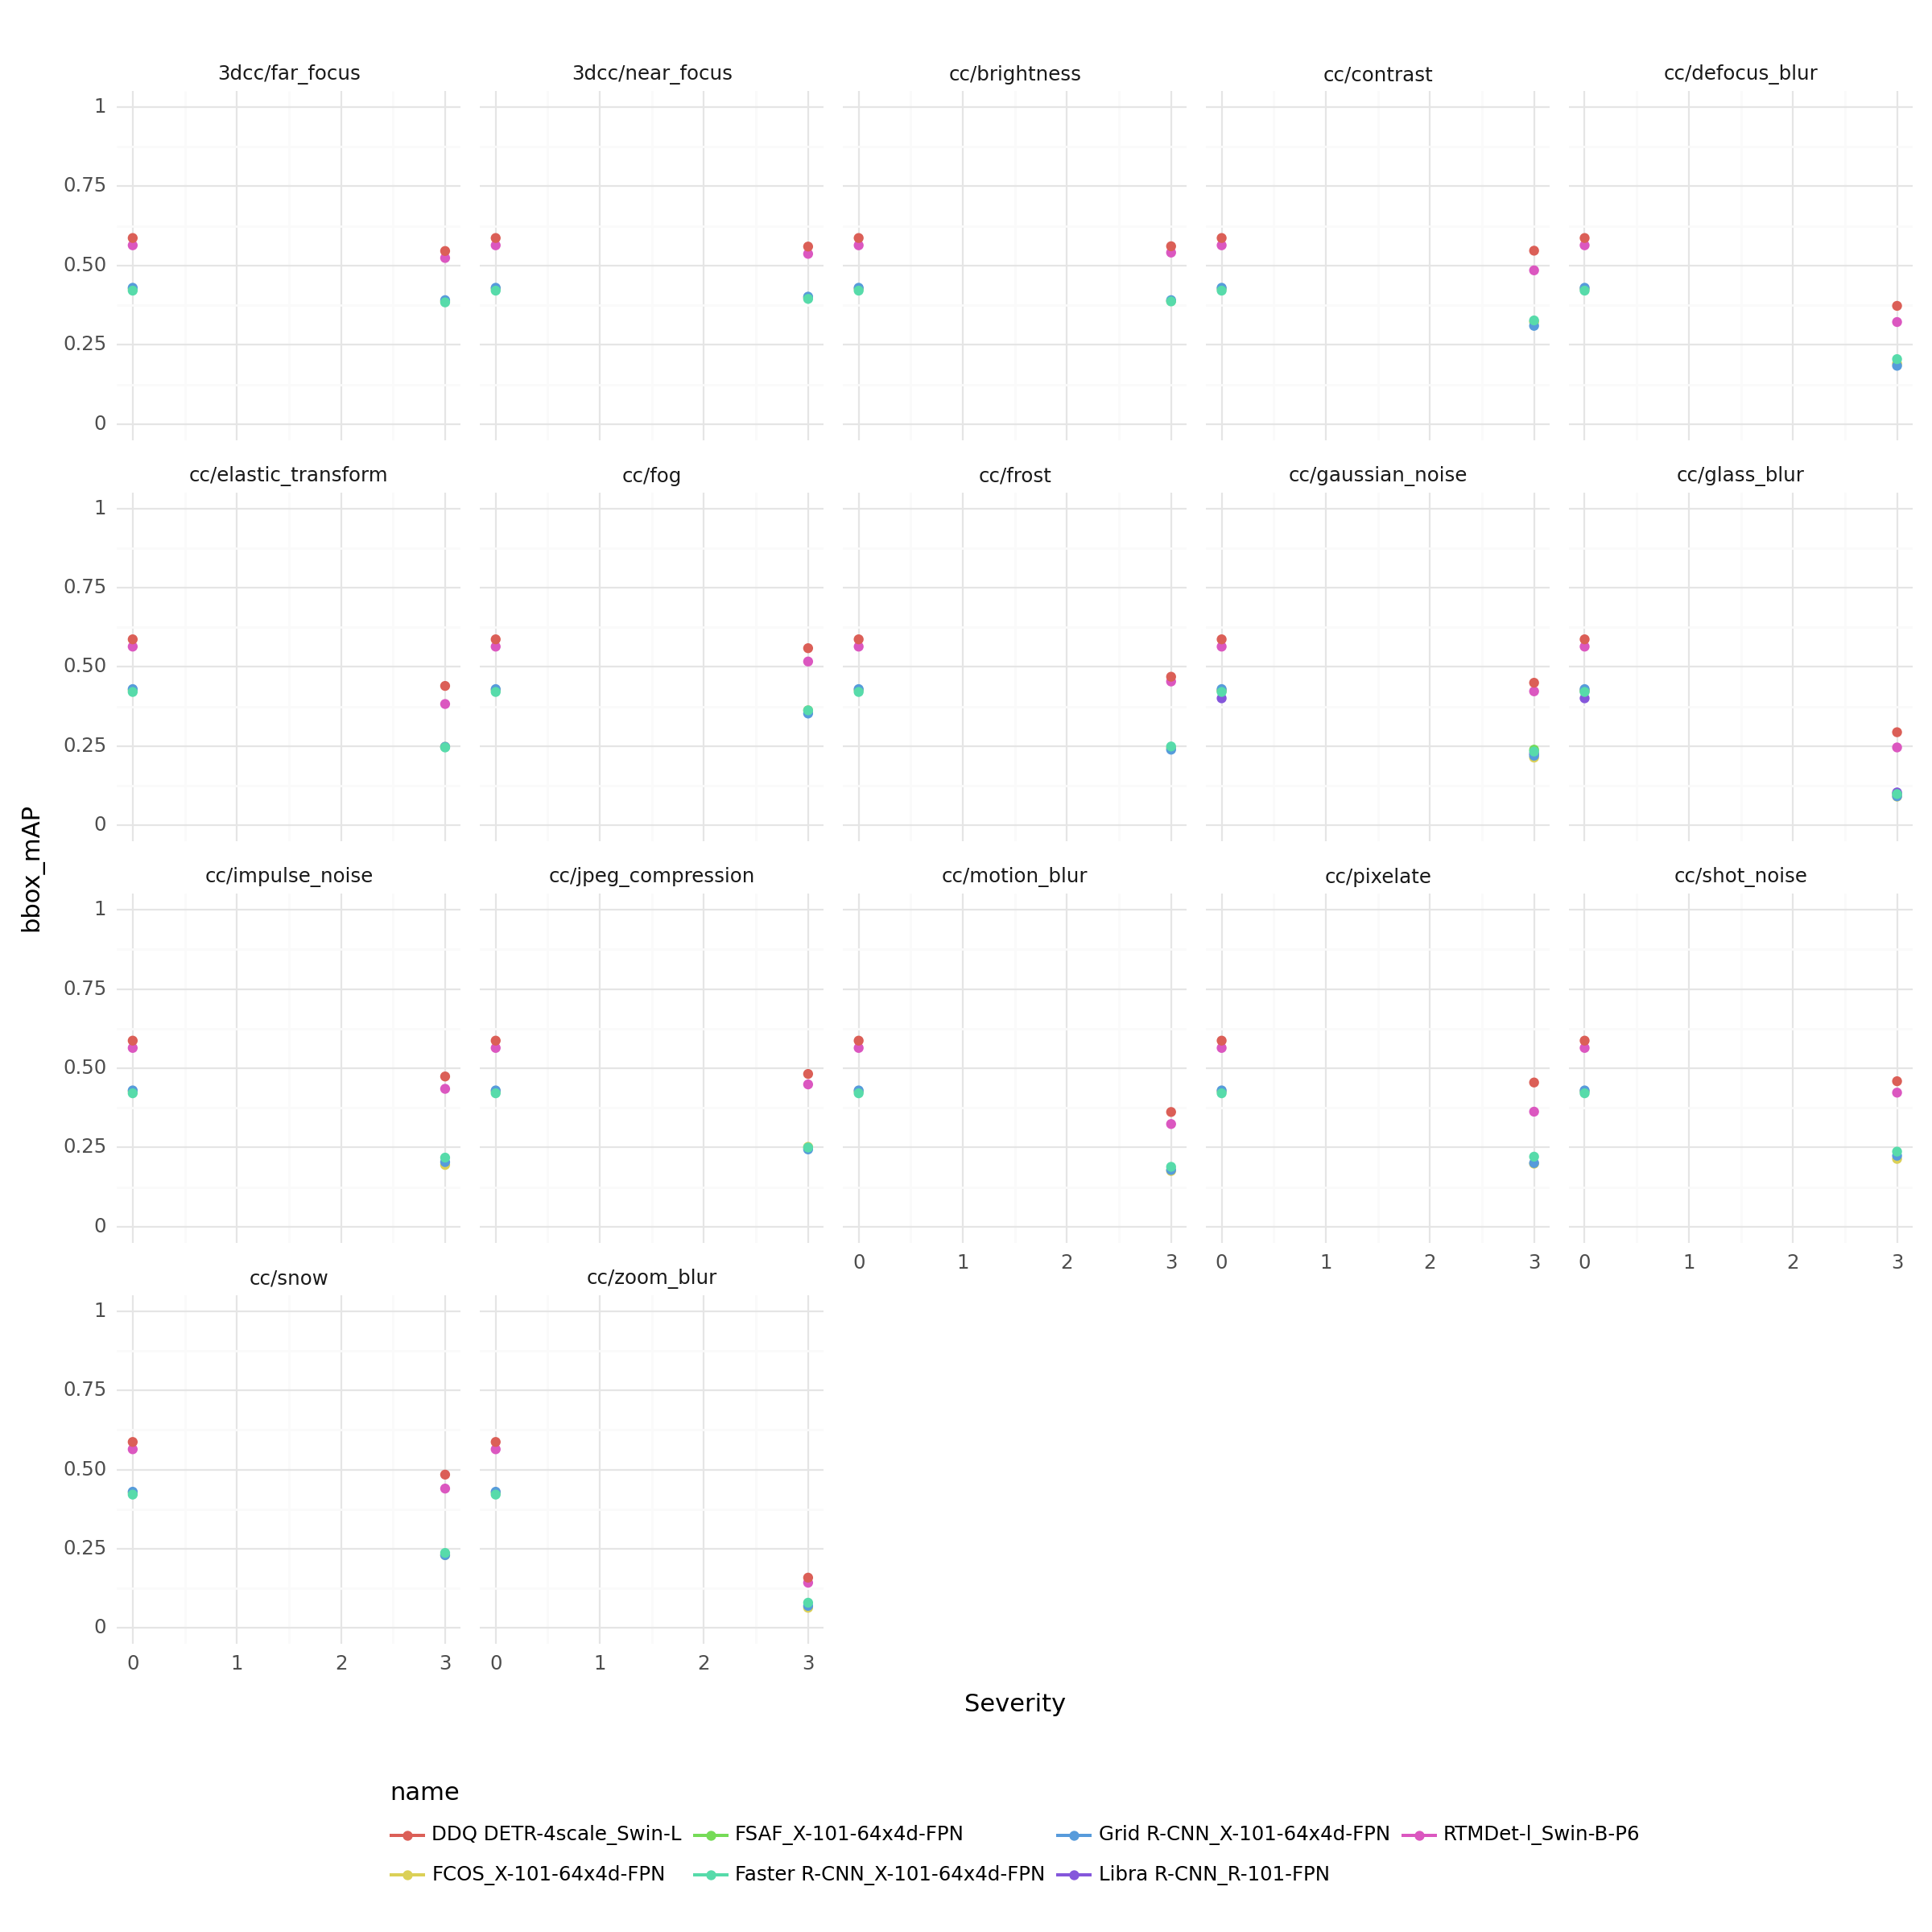

<Figure Size: (1200 x 1200)>

In [23]:
plot_mAP_vs_severity("data/coco/", df)

In [24]:
# plot_mAP_vs_severity("data/VOCdevkit/", df)